# VWAP & TWAP Analysis

This notebook demonstrates how to calculate and analyze VWAP (Volume Weighted Average Price) and TWAP (Time Weighted Average Price) using minute-level trading data. VWAP and TWAP are important metrics for understanding price trends and trade execution quality.

**Note to self:** use open_time as our datetime index for the DataFrame.

**VWAP**
 is the “true average price” paid, where every trade is weighted by how big it was. If heavy trading happened at $700, and light trading at $710, VWAP will sit closer to $700. Traders use it to judge if their execution beat or missed the market’s average.

**TWAP**
 averages the price over fixed time intervals, treating each minute equally. It’s like saying “let’s split the day into 60 equal chunks and average their prices.” A benchmark when you want to smooth out short bursts and focus on a steady, time-based trend.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parse the open_time column as datetime and set it as the index.

In [2]:
df = pd.read_csv('/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv', parse_dates=['open_time'], index_col='open_time')
df.head()

,close_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,timestamp
open_time,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:59.999,8.5478,8.5478,8.5300,8.5300,193.48,1650.404500,6,1.00,8.547800,1514764800
2018-01-01 00:01:00,2018-01-01 00:01:59.999,8.5300,8.5300,8.5300,8.5300,78.38,668.581400,6,0.00,0.000000,1514764860
2018-01-01 00:02:00,2018-01-01 00:02:59.999,8.5300,8.5300,8.5145,8.5145,71.39,608.258124,9,1.00,8.530000,1514764920
2018-01-01 00:03:00,2018-01-01 00:03:59.999,8.5065,8.5299,8.4848,8.4848,1546.82,13150.125692,45,2.91,24.773909,1514764980
2018-01-01 00:04:00,2018-01-01 00:04:59.999,8.5009,8.5066,8.4744,8.5066,125.80,1066.760100,14,24.88,211.506164,1514765040


Define two functions to compute VWAP and TWAP:
- compute_vwap: calculates the cumulative VWAP or rolling VWAP over a specified window.
- compute_twap: calculates the rolling TWAP over a specified window.

VWAP weights prices by volume, while TWAP is a simple average over time.

In [4]:
def compute_vwap(df, window=None):
    price = df['close']
    volume = df['volume']
    if window is None:
        vwap = (price * volume).cumsum() / volume.cumsum()
    else:
        vwap = (price * volume).rolling(window=window).sum() / volume.rolling(window=window).sum()
    return vwap

def compute_twap(df, window):
    twap = df['close'].rolling(window=window).mean()
    return twap

We now compute both the rolling VWAP and TWAP using a 15-minute window to compare their behavior over the same time frame.

In [ ]:
window = 60  
df['vwap_60m'] = compute_vwap(df, window=window)
df['twap_60m'] = compute_twap(df, window=window)

Finally, we plot the price, VWAP, and TWAP on the same chart for visual comparison. This helps us understand how the two averages track price movements differently.

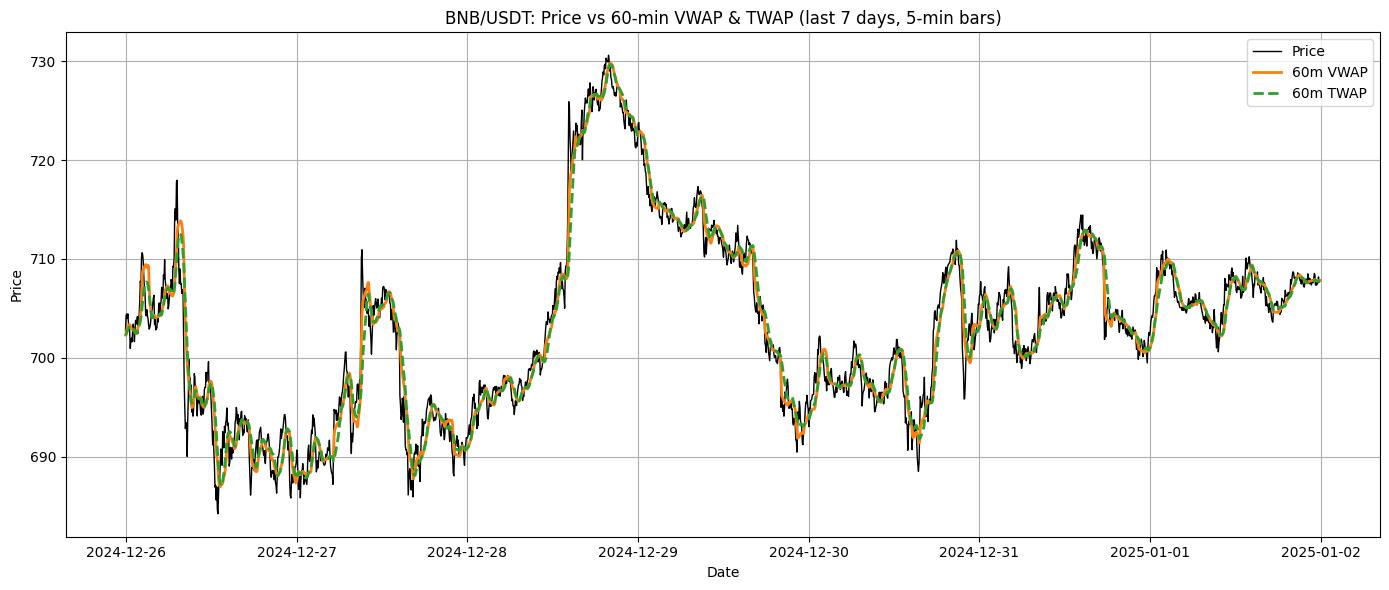

In [ ]:
# Turn that UNIX-sec “timestamp” column into real datetime, then index on it
df['ts'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('ts')

# Compute 60-minute TWAP & VWAP
df['twap_60m'] = df['close'].rolling('60min').mean()
#    VWAP weights price by volume
pv = (df['close'] * df['volume']).rolling('60min').sum()
vol = df['volume'].rolling('60min').sum()
df['vwap_60m'] = pv / vol

# Grab only the last 7 days
cutoff = df.index.max() - pd.Timedelta(days=7)
last7 = df.loc[df.index >= cutoff].copy()

# Down-sample to 5-minute bars so the 3 lines separate visually
plot_df = pd.DataFrame({
    'Price':    last7['close'].resample('5min').last(),
    '60m VWAP': last7['vwap_60m'].resample('5min').mean(),
    '60m TWAP': last7['twap_60m'].resample('5min').mean(),
}).dropna()

# Plot
plt.figure(figsize=(14,6))
plt.plot(plot_df.index, plot_df['Price'],
         color='black', linestyle='-',  label='Price',   linewidth=1)
plt.plot(plot_df.index, plot_df['60m VWAP'],
         color='C1', linestyle='-',  label='60m VWAP', linewidth=2)
plt.plot(plot_df.index, plot_df['60m TWAP'],
         color='C2', linestyle='--', label='60m TWAP', linewidth=2)

plt.title("BNB/USDT: Price vs 60-min VWAP & TWAP (last 7 days, 5-min bars)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Summary

- **VWAP** is useful when you want to understand the average price weighted by volume, which reflects the price levels where most trading occurred.
- **TWAP** is a simple average over time and is helpful for evenly distributing trades or analyzing price trends without volume bias.

Use VWAP when volume information is important for your analysis or trading strategy, and TWAP when you want a time-based average price.